In [1]:
import pandas as pd
import numpy as np
import math
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp

In [2]:
data_folder = 'data/'
extension = '.csv.gz'
build_path = lambda x: data_folder + x + extension

real_dataset_file = build_path('real_dataset')
loose_dataset_file = build_path('loose_dataset')
strict_dataset_file = build_path('strict_dataset')
malwr_file_info_file = build_path('malwr_file_info')

malwr_imports_file = build_path('malwr_imports')
malwr_imports_invalid_file = build_path('malwr_imports_invalid')

cv_token_pattern = u'[^;]+'

In [3]:
malwr_file_info = pd.read_csv(malwr_file_info_file).set_index('link')
malwr_file_info.start_time = pd.to_datetime(malwr_file_info.start_time)
malwr_file_info.sort_values(by='start_time', inplace=True)
real_dataset = pd.read_csv(real_dataset_file).set_index('link')
loose_dataset = pd.read_csv(loose_dataset_file).set_index('link')
strict_dataset = pd.read_csv(strict_dataset_file).set_index('link')

malwr_imports = pd.read_csv(malwr_imports_file, dtype=str).set_index('link')
invalid_imports = list(pd.read_csv(malwr_imports_invalid_file)['0'])

mal_classes = ['other', 'ransom', 'spyware', 'trojan', 'virus', 'worm']

In [12]:
final_rocs = []

In [19]:
#dataset = strict_dataset.join(malwr_imports)
#dataset = loose_dataset.join(malwr_imports)
dataset = real_dataset.join(malwr_imports)
malware = dataset.dropna(how='all', subset=mal_classes).index
goodware = dataset[~dataset.index.isin(malware)].index
dataset = dataset.join(malwr_file_info.start_time).sort_values(by='start_time')
dataset.loc[malware, 'is_malware'] = 1
dataset.loc[goodware, 'is_malware'] = 0

In [20]:
cv = CountVectorizer(token_pattern=cv_token_pattern, stop_words=invalid_imports, lowercase=False)
cv.fit(dataset.imports)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['!', '&\\xe8', '&^', '(&', '*invalid*', '5\\xd5b\\xf0\\xfd', '=SVBVM60.DLL', 'ADVAPI32.dll\\x85', 'C:\\Program', 'C:\\windows\\system32\\msvbvm60', 'GDI32.\\x90ll', 'MSVB\\x90M60.DLL', 'MSVCP60.dll\\x90', 'MSVCRT.dll\\x85', 'MSVCRT.dll\\x90', 'MZ\\x90', 'OL\\x90AUT32.dll', 'WS2_32.DLL\\x...L', 'avicap32.dll\\x99', 'mscoree.$ml', 'rasapi32.dll\\x90', 'shell32.dll\\x90', 'wsock32.dll\\x90'],
        strip_accents=None, token_pattern='[^;]+', tokenizer=None,
        vocabulary=None)

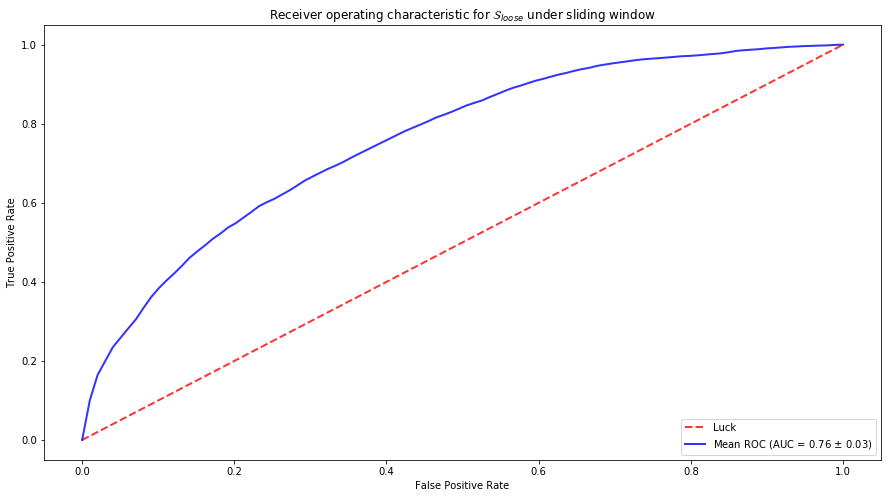

In [21]:
#%%time
# 4716 training size
# 3932 validation size
# 8648 Total size

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fold_size = test_size = int(len(dataset) / 10)
train_size = fold_size * 4

plt.figure(figsize=(15, 8))

start = 0
for i in range(6):
    train_data = dataset[start:start+train_size]
    test_data = dataset[start+train_size:start+train_size+test_size]
    
    start += fold_size
    
    
    # Get second layer input
    classifiers = dict()
    for mclass in mal_classes:
        mal = train_data[~train_data[mclass].isna()]
        not_mal = train_data[~train_data.index.isin(mal.index)]
        
        mal.is_copy = False
        not_mal.is_copy = False
        mal.loc[:, 'is_malware'] = 1
        not_mal.loc[:, 'is_malware'] = 0
        
        data = pd.concat([mal, not_mal]).sort_values('start_time')
        
        x1 = cv.transform(data.imports)
        y1 = data.is_malware
        
        classifier = LogisticRegression(C=1)
        classifiers[mclass] = classifier.fit(x1, y1)
    
    inputs = dict()
    for mclass in mal_classes:
        inputs[mclass] = classifiers[mclass].predict_proba(
            cv.transform(train_data.imports))[:, 1]

    x_test = cv.transform(test_data.imports)
    y_test = test_data.is_malware
    x = np.array([classifiers[mclass].predict_proba(x_test)[:, 1] for mclass in mal_classes]).transpose()
    x_train = pd.DataFrame(inputs)
    y_train = train_data.is_malware
    probas_ = LogisticRegression(C=1).fit(x_train, y_train).predict_proba(x)
        
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    #plt.plot(fpr, tpr, lw=1, alpha=0.3,
#             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for $\mathcal{S}_{loose}$ under sliding window')
plt.legend(loc="lower right")
plt.show()

final_rocs += [(mean_fpr, mean_tpr)]

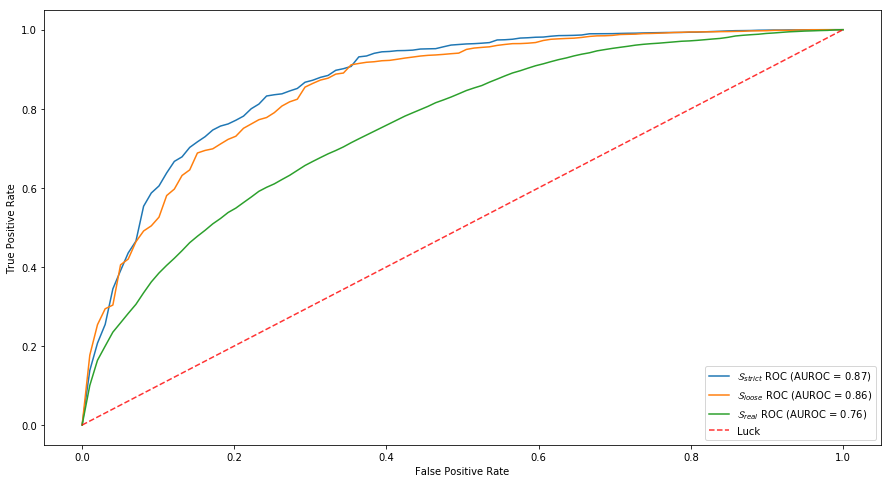

In [23]:
plt.figure(figsize=(15, 8))

fpr, tpr = final_rocs[0]
plt.plot(fpr, tpr, label='$\mathcal{S}_{strict}$ ROC (AUROC = %0.2f)' % (auc(fpr, tpr)))
fpr, tpr = final_rocs[1]
plt.plot(fpr, tpr, label='$\mathcal{S}_{loose}$ ROC (AUROC = %0.2f)' % (auc(fpr, tpr)))
fpr, tpr = final_rocs[2]
plt.plot(fpr, tpr, label='$\mathcal{S}_{real}$ ROC (AUROC = %0.2f)' % (auc(fpr, tpr)))
#for fpr, tpr in final_rocs:
#    roc_auc = auc(fpr, tpr)
#    plt.plot(fpr, tpr, label='ROC (AUROC = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='r',
         label='Luck', alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic - Sliding Window')
plt.legend(loc="lower right")
plt.show()